# Impact of Food Delivery Services and Population Density on Yelp Restaurant Ratings

# Project One

## Introduction


Online review platforms play a significant role in influencing business performance during this era of digital connectivity and evolving customer behaviors, with Yelp standing out as one of the foremost review sites. Research by Anderson & Magruder (2012) indicates that an additional half-star rating on Yelp can lead to a substantial increase, of over 19 percentage points, in the frequency of prime-time table reservations at restaurants. This observation aligns with Luca's findings in 2011, underscoring the pivotal role that Yelp ratings (in the form of stars) play in shaping business outcomes, directly impacting revenue generation.


Yelp has its own rating system based on the ratings of each review,it involves a weighted average algorithm incorporating review quality, quantity, business rating, recency, and user behavior. The process includes automated filters to detect biased or fake reviews and categorical ratings for specific aspects like service and ambiance. Yelp's recommendation software showcases relevant reviews while excluding low-quality ones. It is worth mentioning that researchers predict star ratings through sentiment analysis of review texts, capturing emotional tones (Li & Zhang, 2014), while it is also considered as the review part in this paper. 


My interest is firmly rooted in discerning the other factors that contribute to the determination of Yelp ratings indirectly, utilizing the dataset provided by the Yelp Dataset Challenge (2017). This dataset comprehensively encompasses vital information about Yelp businesses, including ratings, geographical locations, review counts, and categories, spanning across 11 metropolitan areas in four countries. This comprehensive dataset forms the cornerstone of my research investigation.

Having acquired the census dataset for each zip code and the map shape-file from the United States Census Bureau, my focus shifted to discerning crucial determinants aside from the factors of Yelp rating algorithm. Among these, population density surfaced as a compelling variable, supported by evidence indicating that heightened population density engenders a notable reduction in the spatial dispersion of both top-tier and lower-tier restaurants (Mossay et al., 2020). As increased population density often signifies a concentrated market where competition becomes more intense, potentially leading to enhanced quality control and a narrower range of restaurant performance, which could thus affect the restaurant’s ratings.

Moving forward, the variable of household income assumes pivotal significance. Established scholarship posits its pivotal role in influencing not only the choice to dine at restaurants but also culinary preferences, quality perceptions, and nutritional decisions (Bellisle, 2006) (Mulamba, 2022). The economic rationale here lies in the notion that higher household incomes can provide individuals with the means to prioritize and afford dining out, thereby potentially shaping both their expectations and evaluations of restaurant experiences. While scholarly literature does not extensively corroborate the notion, it's worth noting Feefo's research findings. This research highlights the potential impact of reviewers’ age and sex on their reviews, offering a glimpse into how demographic variables might subtly influence rating behaviors (Gorkana News, 2016). Economically speaking, age and sex can influence dining patterns, satisfaction thresholds, and the criteria individuals use to evaluate their experiences.

In this intricate web of factors, population density mirrors competitive dynamics of the restaurants; and in the consumer side, household income reflects economic capacity and preferences, while age and sex ratio hint at different groups’ dining habits and satisfaction thresholds. All these variables, nestling within the census dataset of individual zip codes, are poised to act as independent drivers of Yelp restaurant ratings.

This study embarks on a parallel narrative exploration within the United States, inspired by research centred on China's ongoing urbanization during the recent years. The phenomenon in China has led to a surge in food delivery services and prompted traditional businesses to transition towards online platforms. Notably, it was found that more than one-fifth of China's total population has become part of the O2O food delivery market (Maimaiti et al., 2018). Urbanization, marked by population concentration in larger cities, typically brings about increases in population density and mean income. Drawing inspiration from this, the study aims to unravel a similar narrative within the context of the United States. The focus is on examining the intricate interplay of factors influencing restaurant popularity, the expanding realm of food delivery services, and the dynamic shifts in demographic landscapes. Elements such as population density, household income, age, and sex ratio are under scrutiny, using the case study of Arizona. This study's primary inquiry concerns whether Yelp-listed restaurants that provide food delivery services are more likely to prosper as population densities rise.



## Data Cleaning

In [1]:
%%capture
!pip install tabulate
!pip install descartes
!pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
import geopandas as gpd
from shapely.geometry import Point
%matplotlib inline
import qeds
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

In [3]:
# Load the Yelp business dataset
base0 = pd.read_csv("yelp_business.csv")
base = pd.DataFrame(base0)
state_counts = base['state'].value_counts()
top_11_states = state_counts.index[:11]
base['state_category'] = base['state'].apply(lambda x: x if x in top_11_states else 'NFI') # Need Further Investigation

In [4]:
# Data Cleaning: Filter restaurants with "Restaurant", and categorize by "Food delivery" or not
restaurant = base[base['categories'].str.contains('Restaurant', case=False, na=False) & base['categories'].str.contains('Food', case=False, na=False) | base['categories'].str.contains('Delivery', case=False, na=False)]
delivery = restaurant[restaurant['categories'].str.contains('Delivery', case=False, na=False)]
non_delivery = restaurant[~restaurant['categories'].str.contains('Delivery', case=False, na=False)]

restaurant_delivery = restaurant.copy()
restaurant_delivery['has_food_delivery'] = restaurant_delivery['categories'].str.contains('Delivery', case=False, na=False)

# Filter restaurants in Arizona (AZ)
AZ = restaurant_delivery[restaurant_delivery['state_category'] == 'AZ']
AZ_T = AZ.loc[restaurant_delivery['has_food_delivery'] == True]
AZ_F = AZ.loc[restaurant_delivery['has_food_delivery'] == False]

AZ_co = AZ.copy()
AZ_co["Coordinates"] = list(zip(AZ_co.longitude, AZ_co.latitude))
AZ_co["Coordinates"] = AZ_co["Coordinates"].apply(Point)

In pursuit of our research goal, I focus solely on establishments categorized as "Restaurant." This refinement helps narrow our study scope.It involves categorizing restaurants based on their state, filtering for those that include ley words like "Restaurant", "food" in their categories. To delve into the influence of food delivery, a binary subcategory termed "Has food delivery" is generated based on the presence or absence of "Food Delivery" in the "categories" column. Additionally, I will import a Population dataset with the Zip code as the key from census data.

As mentioned before, I have gained the access to 13 variables from the Yelp business dataset: “Business id,” “name,” “neighbourhood,” “address,” “city,” “state,” “postal code,” “latitude,” “longitude,” “stars,” “Review count,” “Is open,” and “categories.” In this case, The  business id, their names, specifc address, and openins status are insignificance to our study because we need a comprehensive view of all businesses; “city,” “state,” “postal code,” “latitude,” and “longitude” are indicating the location of the business; as I will concentrate on US restaurants, I will keep “state”. “postal code”, “latitude”, “longitude” will help me locate the restaurants in the map, and use this to merge with the population dataset in the future. 

The crux of our investigation revolves around assessing the impact of food delivery services on restaurant success, measured by Yelp ratings ("stars"). Consequently, "stars" takes on the role of the dependent variable (Y variable), capturing the ratings assigned to each restaurant. I will first require the “categories”that forms the foundation of our independent variables (X variables). Notably, the presence of the "Has food delivery" subcategory serves as a critical factor in examining food delivery service effects. Despite a direct correlation not being immediately evident, the "Review count" variable retains its importance due to its potential relevance in gauging restaurant popularity. Hence, it remains a pivotal numerical variable in our analysis.

### New merged datasets (For final project)

In [5]:
%%capture
# Import the state and Zip code dataset for the map
state_df = gpd.read_file("http://www2.census.gov/geo/tiger/GENZ2016/shp/cb_2016_us_state_5m.zip")
zip_df = gpd.read_file("d1/Shapefile_az/tl_2019_us_zcta510.shp")
#Specify the atate to Arizona
arizona_state_df = state_df[state_df['STUSPS'] == 'AZ']
# ZIP codes in Arizona starting with "85" and "86"
arizona_zip_df = zip_df[zip_df['ZCTA5CE10'].str.startswith(("85", "86"))]


ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


In [6]:
#Import the Population dataset with the Zip code as the Key
popu = pd.read_csv("Population.csv")
pop = pd.DataFrame(popu)
# Replace "NaN" with actual NaN values
pop['Total'] = pop['Total'].replace('NaN', pd.NA)
# Convert 'Total' column to numeric
pop['Total'] = pd.to_numeric(pop['Total'].str.replace(',', ''), errors='coerce')
pop['postal_code'] = pop['Label'].str.extract(r'ZCTA5 (\d+)')
pop_cleaned = pop.dropna()
pop_cleaned = pop_cleaned.reset_index(drop=True)
pop_cleaned = pop_cleaned.sort_values(by='Total', ascending=True)

In [7]:
# merge the zip data and the population data
zip_states_pop = arizona_zip_df.merge(pop_cleaned, left_on="ZCTA5CE10", right_on="postal_code", how="inner")
zip_states_pop['population_density'] = zip_states_pop['Total'] / zip_states_pop['ALAND10'] * 100

In [8]:
# merge the zip data and the stars data
merged_df = pd.merge(pop_cleaned, AZ_co, on='postal_code')
average_stars_by_postal_code = merged_df.groupby('postal_code')['stars'].mean() # this is the total average
average_star = pd.DataFrame(average_stars_by_postal_code)

merged_T = pd.merge(pop_cleaned, AZ_T, on='postal_code')
merged_F = pd.merge(pop_cleaned, AZ_F, on='postal_code')
average_stars_by_postal_codet = merged_T.groupby('postal_code')['stars'].mean()
average_star_T = pd.DataFrame(average_stars_by_postal_codet) # this is the average stars of restaurants that delivery food
average_stars_by_postal_codef = merged_F.groupby('postal_code')['stars'].mean() 
average_star_F = pd.DataFrame(average_stars_by_postal_codef) # this is the average stars of restaurants that not delivery food

In [9]:
zip_states_star_avg = arizona_zip_df.merge(average_star, left_on="ZCTA5CE10", right_on="postal_code", how="inner")

In [10]:
zip_states_star_F = zip_states_star_avg.merge(average_star_F, left_on="ZCTA5CE10", right_on="postal_code", how="left")

In [11]:
zip_states_star_total = zip_states_star_F.merge(average_star_T, left_on="ZCTA5CE10", right_on="postal_code", how="left")
# stars_x: Total average stars
# stars_y: Average star for restaurant that no provide food delivery service
# stars: Average star for restaurant that provide food delivery service

In [12]:
zip_states_total = zip_states_star_total.merge(zip_states_pop, on="ZCTA5CE10", how="left")
selected_cols_total = ['ZCTA5CE10', 'GEOID10_x', 'CLASSFP10_x', 'MTFCC10_x', 'FUNCSTAT10_x', 'ALAND10_y', 'INTPTLAT10_x', 'INTPTLON10_x', 'geometry_x', 'Total', 'stars_x', 'stars_y', 'stars']
zip_states_total = zip_states_total[selected_cols_total]
zip_states_total.rename(columns={'GEOID10_x': 'GEOID10'}, inplace=True)
zip_states_total.rename(columns={'CLASSFP10_x': 'CLASSFP10'}, inplace=True)
zip_states_total.rename(columns={'MTFCC10_x': 'MTFCC10'}, inplace=True)
zip_states_total.rename(columns={'FUNCSTAT10_x': 'FUNCSTAT10'}, inplace=True)
zip_states_total.rename(columns={'INTPTLAT10_x': 'INTPTLAT10'}, inplace=True)
zip_states_total.rename(columns={'INTPTLON10_x': 'INTPTLON10'}, inplace=True)
zip_states_total.rename(columns={'geometry_x': 'geometry'}, inplace=True)
zip_states_total.rename(columns={'ALAND10_y': 'ALAND10'}, inplace=True)

zip_states_total.rename(columns={'stars_x': 'Total_stars'}, inplace=True)
zip_states_total.rename(columns={'stars_y': 'Non_FD_star'}, inplace=True)
zip_states_total.rename(columns={'stars': 'FD_star'}, inplace=True)
zip_states_total['population_density'] = zip_states_total['Total'] / zip_states_total['ALAND10'] * 100
# Population density is number of people/100 square meters

In [13]:
%%capture
# Import and clean the Income, Age dataset
Income = pd.read_csv("HouseholdIncome.csv")
selected_income = ['NAME', 'S1902_C03_001E' ]
Income = Income[selected_income]
Income.rename(columns={'NAME': 'postal_code'}, inplace=True)
Income['postal_code'] = Income['postal_code'].str.extract(r'ZCTA5 (\d+)')
Income.rename(columns={'S1902_C03_001E': 'Mean_Income'}, inplace=True) # Estimate!!Mean income (dollars)
Income = pd.DataFrame(Income)
Income = Income.drop(0)
Income = Income.reset_index(drop=True)
Income['Mean_Income'] = pd.to_numeric(Income['Mean_Income'], errors='coerce')
Income['Mean_Income'] = np.log(Income['Mean_Income'])
zip_states_Income = arizona_zip_df.merge(Income, left_on="ZCTA5CE10", right_on="postal_code", how="inner")

Age = pd.read_csv("Ages.csv")
selected_Age = ['NAME', 'DP05_0001E', 'DP05_0004E','DP05_0008E','DP05_0009E']
Age = Age[selected_Age]
Age.rename(columns={'NAME': 'postal_code'}, inplace=True)
Age['postal_code'] = Age['postal_code'].str.extract(r'ZCTA5 (\d+)')
Age.rename(columns={'DP05_0001E': 'Total_pop'}, inplace=True) 
Age.rename(columns={'DP05_0004E': 'Sex_ratio'}, inplace=True) 
Age.rename(columns={'DP05_0008E': 'Pop_15_19'}, inplace=True) 
Age.rename(columns={'DP05_0009E': 'Pop_20_24'}, inplace=True) 
Age = pd.DataFrame(Age)
Age = Age.drop(0)
Age = Age.reset_index(drop=True)
Age["Pop_15_19"] = Age["Pop_15_19"].astype(float)
Age["Pop_20_24"] = Age["Pop_20_24"].astype(float)
Age["Total_pop"] = Age["Total_pop"].astype(float)
Age["Pop_15_24"] = Age["Pop_15_19"] + Age["Pop_20_24"]
Age["Pop_15_24"] = ((Age["Pop_15_24"] / Age["Total_pop"]) * 100).round(2)

# Merge the Income, Age(Percentage of young people from 15-24), Sex (Number of males for 100 females), Eduaction(Percentage of high education) into the zip dataset
Final_total = zip_states_total.merge(Income, left_on="ZCTA5CE10", right_on="postal_code", how="left")
Final_total = Final_total.merge(Age, left_on="ZCTA5CE10", right_on="postal_code", how="left")

# Clean the merged dataset and select the variables for the regression
Final_regression = Final_total[['ZCTA5CE10',  'ALAND10', 'Total', 'population_density','Pop_15_24', 'Mean_Income','Sex_ratio','Total_stars']]
Final_regression['Sex_ratio'] = pd.to_numeric(Final_regression['Sex_ratio'], errors='coerce')

# Add new variable which is how many restaurants in total in each zip code
merged_df = pd.merge(pop_cleaned, AZ_co, on='postal_code')
grouped_df = merged_df.groupby('postal_code')
postal_code_counts = grouped_df['postal_code'].value_counts()
Number_res = pd.DataFrame(postal_code_counts)
zip_states_count = arizona_zip_df.merge(Number_res, left_on="ZCTA5CE10", right_on="postal_code", how="inner")

Final_regression = Final_regression.merge(Number_res, left_on="ZCTA5CE10", right_on="postal_code", how="left")
Final_regression_merged = Final_regression.merge(AZ_co, left_on="ZCTA5CE10", right_on="postal_code", how="outer")
Final_regression_merged = Final_regression_merged.dropna(subset=['ZCTA5CE10']) # Clean the NAs
Final_regression_merged['has_food_delivery'] = Final_regression_merged['has_food_delivery'].astype(int)
# New variable: the ratio of food delivery service in each zip code
percentage_delivery = Final_regression_merged.groupby('ZCTA5CE10').apply(
    lambda group: (group['has_food_delivery'] == 1).sum() / group['count'] * 100
).reset_index(name='percentage_delivery')
zip_states_nfd = arizona_zip_df.merge(percentage_delivery, left_on="ZCTA5CE10", right_on="ZCTA5CE10", how="inner")
# Merge the calculated percentages back to the original DataFrame
Final_regression_merged = Final_regression_merged.merge(percentage_delivery, on='ZCTA5CE10', how='left')
print(zip_states_nfd)

By integrating population data for each zip code with detailed map shapefile information from the United States Census Bureau, I've obtained a comprehensive understanding of geographic locations (longitude and latitude ranges) and land areas. This data synergy has enabled me to effortlessly compute population density by dividing the population figure by the land area, introducing a crucial variable named "population density." This newly introduced metric has proven to be immensely insightful, unveiling the concentration of residents across distinct zip code regions. Consequently, it serves as a pivotal indicator for evaluating potential customer bases and gauging the demand for food services within these areas.

Moreover, my data aggregation efforts extend to importing the Income and Age dataset from the United States Census Bureau. This dataset encompasses two vital dimensions: mean household income and age demographics. The former provides a nuanced understanding of the economic landscape, allowing for the identification of areas with greater financial capacity to engage in food-related expenditures, including dining out and catering services. Meanwhile, the age demographics component delves into the composition of each zip code's population. This encompasses the sex ratio, representing the ratio of males to females per 100 individuals, as well as the percentage of young people (aged range from 15 to 24) within the overall population for each zip code in Arizona. 


## Summary Statstics Tables

In this section, I show the summary statistics tables for the 'stars' and 'review_count' columns in the whole dataset, as well as creating formatted tabular summaries for the ratings and review counts based on different states. After merging the new datasets from the United States Census Bureau, I demonstrate the summary statistics tables for though new variables as the 'population', the land area of each zip code,

In [14]:
summary_stats = base[['stars', 'review_count']].describe()
print(summary_stats)   

               stars   review_count
count  174567.000000  174567.000000
mean        3.632196      30.137059
std         1.003739      98.208174
min         1.000000       3.000000
25%         3.000000       4.000000
50%         3.500000       8.000000
75%         4.500000      23.000000
max         5.000000    7361.000000


The 'Stars' column shows that the average star rating for restaurants in the dataset is around 3.63, with a median of  3.50. The minimum star is 1, and the maximum is 5.

The 'Review count' column reveals that the average number of reviews for restaurants is about 30.14, with a median of  8.00. The minimum review count is 3, and the maximum is as high as 7361.

In [15]:
# Summary table for stars
stars_summary = base.groupby('state_category').agg({
    'stars': ['mean', 'median', 'min', 'max', lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)],
    'categories': 'count'
}).reset_index()
stars_summary.columns = ['State', 'Mean', 'Median', 'Min', 'Max',  '25%', '75%', 'Count']
stars_summary['Mean'] = stars_summary['Mean'].round(2)

# Summary table for review counts
review_summary = base.groupby('state_category').agg({
    'review_count': ['mean', 'median', 'min', 'max', lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)],
    'categories': 'count'
}).reset_index()
review_summary.columns = ['State', 'Mean', 'Median', 'Min', 'Max', '25%', '75%', 'Count']
review_summary['Mean'] = review_summary['Mean'].round(2)

tabular_stars_summary = tabulate(stars_summary, headers='keys', tablefmt='pretty')
tabular_review_summary = tabulate(review_summary, headers='keys', tablefmt='pretty')
print("Stars Summary:")
print(tabular_stars_summary)
print("\nReview Summary:")
print(tabular_review_summary)

Stars Summary:
+----+-------+------+--------+-----+-----+-----+-----+-------+
|    | State | Mean | Median | Min | Max | 25% | 75% | Count |
+----+-------+------+--------+-----+-----+-----+-----+-------+
| 0  |  AZ   | 3.73 |  4.0   | 1.0 | 5.0 | 3.0 | 4.5 | 52214 |
| 1  |  BW   | 3.81 |  4.0   | 1.0 | 5.0 | 3.5 | 4.5 | 3118  |
| 2  |  EDH  | 3.78 |  4.0   | 1.0 | 5.0 | 3.5 | 4.5 | 3795  |
| 3  |  IL   | 3.49 |  3.5   | 1.0 | 5.0 | 3.0 | 4.5 | 1852  |
| 4  |  NC   | 3.57 |  3.5   | 1.0 | 5.0 | 3.0 | 4.5 | 12956 |
| 5  |  NFI  | 3.65 |  3.5   | 1.0 | 5.0 | 3.0 | 4.5 | 1697  |
| 6  |  NV   | 3.71 |  4.0   | 1.0 | 5.0 | 3.0 | 4.5 | 33086 |
| 7  |  OH   | 3.54 |  3.5   | 1.0 | 5.0 | 3.0 | 4.5 | 12609 |
| 8  |  ON   | 3.41 |  3.5   | 1.0 | 5.0 | 3.0 | 4.0 | 30208 |
| 9  |  PA   | 3.61 |  3.5   | 1.0 | 5.0 | 3.0 | 4.5 | 10109 |
| 10 |  QC   | 3.66 |  4.0   | 1.0 | 5.0 | 3.0 | 4.5 | 8169  |
| 11 |  WI   | 3.64 |  3.5   | 1.0 | 5.0 | 3.0 | 4.5 | 4754  |
+----+-------+------+--------+-----+----

These tables show the summary statistics of Stars/Review count for each state.

1. The 'Mean' column shows the average Stars/Review count for each state.

2. The 'Median' column shows the median Stars/Review count for each state.

3. The 'Min' and 'Max' columns indicate the minimum and maximum Stars/Review count.

4. The '25%' and '75%' columns represent the 25th and 75th percentiles, respectively, offering insights into the distribution of Stars/Review count within each state.

5. The 'Count' column shows how many restaurants are in each state.

In [16]:
delivery_counts = restaurant_delivery.groupby('has_food_delivery').size().reset_index(name='Count')
# Grouping by 'state' and counting the occurrences
state_counts = restaurant_delivery.groupby('state_category').size().reset_index(name='Count')
print("Restaurant Delivery Counts:")
delivery_table = tabulate(delivery_counts, headers=['has_food_delivery', 'Count'], tablefmt='pretty')
print(delivery_table)
print("\nRestaurant Counts by State:")
state_table = tabulate(state_counts, headers=['State', 'Count'], tablefmt='pretty')
print(state_table)

Restaurant Delivery Counts:
+---+-------------------+-------+
|   | has_food_delivery | Count |
+---+-------------------+-------+
| 0 |       False       | 17964 |
| 1 |       True        | 1078  |
+---+-------------------+-------+

Restaurant Counts by State:
+----+-------+-------+
|    | State | Count |
+----+-------+-------+
| 0  |  AZ   | 4194  |
| 1  |  BW   |  535  |
| 2  |  EDH  |  553  |
| 3  |  IL   |  213  |
| 4  |  NC   | 1512  |
| 5  |  NFI  |  220  |
| 6  |  NV   | 2941  |
| 7  |  OH   | 1689  |
| 8  |  ON   | 4278  |
| 9  |  PA   | 1092  |
| 10 |  QC   | 1254  |
| 11 |  WI   |  561  |
+----+-------+-------+


The first table shows the count of restaurants based on whether they offer food delivery (True) or not (False).
There are 1,078 restaurants that offer food delivery (True).
There are 17,964 restaurants that do not offer food delivery (False).

The second table presents the counts of restaurants in each state category.
For example, in Arizona (AZ), there are 4,194 restaurants.
The table provides a breakdown of restaurant counts for each state category, with the help of this table and histogram below I could select a representitive state for my study.

I could therefore learn from the "Restaurant Delivery Counts" table that the majority of restaurants (17964) do not offer food delivery, while a smaller percentage (1078) do. It means most of the Yelp restaurants have not started providing food delivery services yet, this could be an opportunity. 
The "Restaurant Counts by State" table displays the distribution of restaurants across different state categories. For instance, Ontario (ON) has the highest restaurant count with 4278 restaurants, followed by Arizona (AZ) with 4194 restaurants.
The tables provide insights into the prevalence of food delivery services and the distribution of restaurants among various state categories. This information can be useful for understanding the restaurant landscape in terms of delivery services and geographical distribution at the state level.

### New merged datasets (For final project)

In [17]:
# Land area, population, Population density, Age
summary_stats_new1 = Final_regression[['ALAND10','Total','population_density', 'Pop_15_24']].describe()
summary_stats1 = summary_stats_new1.iloc[1:10, :]
summary_stats1 = summary_stats1.round(2)
headers = summary_stats1.columns.tolist()
stat_labels = ["mean", "std", "min", "25%", "50%", "75%", "max"]
summary_stats1.insert(0, "Statistic", stat_labels)
table_data1 = [summary_stats1.columns.tolist()] + summary_stats1.values.tolist()
formatted_table1 = tabulate(table_data1, headers='firstrow', tablefmt='pretty', numalign='right')
print(formatted_table1)

+-----------+--------------+----------+--------------------+-----------+
| Statistic |   ALAND10    |  Total   | population_density | Pop_15_24 |
+-----------+--------------+----------+--------------------+-----------+
|   mean    | 75532792.93  | 36270.77 |        0.13        |   12.84   |
|    std    | 160984328.38 | 16896.58 |        0.09        |   5.04    |
|    min    |  4115789.0   |  523.0   |        0.0         |   0.82    |
|    25%    | 21384019.25  | 25752.5  |        0.07        |   10.27   |
|    50%    |  27996834.0  | 37953.0  |        0.13        |   12.85   |
|    75%    | 44340187.75  | 46777.25 |        0.19        |   14.95   |
|    max    | 1010525491.0 | 73551.0  |        0.37        |   45.46   |
+-----------+--------------+----------+--------------------+-----------+


In [18]:
# Income, Sex, Education
summary_stats_new2 = Final_regression[['Mean_Income','Sex_ratio','Total_stars', 'count']].describe()
summary_stats2 = summary_stats_new2.iloc[1:10, :]
summary_stats2 = summary_stats2.round(2)
summary_stats2['count'] = summary_stats2['count'].round(0)
headers = summary_stats1.columns.tolist()
stat_labels = ["mean", "std", "min", "25%", "50%", "75%", "max"]
summary_stats2.insert(0, "Statistic", stat_labels)
table_data2 = [summary_stats2.columns.tolist()] + summary_stats2.values.tolist()
formatted_table2 = tabulate(table_data2, headers='firstrow', tablefmt='pretty', numalign='right')
print(formatted_table2)

+-----------+-------------+-----------+-------------+-------+
| Statistic | Mean_Income | Sex_ratio | Total_stars | count |
+-----------+-------------+-----------+-------------+-------+
|   mean    |    11.25    |   98.25   |    3.31     | 35.0  |
|    std    |    0.39     |   9.21    |    0.42     | 28.0  |
|    min    |    10.43    |   70.4    |     1.5     |  1.0  |
|    25%    |    11.02    |   93.52   |     3.1     | 16.0  |
|    50%    |    11.2     |   97.45   |    3.33     | 30.0  |
|    75%    |    11.55    |   101.1   |    3.54     | 46.0  |
|    max    |    12.45    |   139.6   |     5.0     | 175.0 |
+-----------+-------------+-----------+-------------+-------+


1. **ALAND10 (Land Area)**:
   - The mean land area across the zip codes in Arizona is approximately 75,532,792.93 square meters.
   - Land areas vary significantly, as indicated by the standard deviation of around 160,984,328.38.
   - The smallest land area recorded is about 4,115,789 square meters.
   - The 25th percentile suggests that 25% of zip codes have land areas below 21,384,019.25 square meters.
   - The median (50th percentile) land area is around 27,996,834 square meters, indicating the middle value.
   - The 75th percentile indicates that 75% of zip codes have land areas below 44,340,187.75 square meters.
   - The largest land area recorded is approximately 1,010,525,491 square metersunits.


2. **Total (Total Population)**:
   - The mean total population of the zip codes is approximately 36,270.77.
   - Population counts vary significantly, with a standard deviation of around 16,896.58.
   - The smallest population count is 523 individuals.
   - The 25th percentile suggests that 25% of zip codes have populations below 25,752.5.
   - The median population count is around 37,953, representing the middle value.
   - The 75th percentile indicates that 75% of zip codes have populations below 46,777.25.
   - The largest population count is 73,551 individuals.


3. **Population Density**:
   - The mean population density is approximately 0.13 individuals per unit area.
   - Population density values have relatively low variability, with a standard deviation of about 0.09.
   - The minimum recorded population density is very low, indicating sparsely populated areas.
   - The 25th percentile suggests that 25% of zip codes have population densities below 0.07 individuals per unit area.
   - The median population density is around 0.13 individuals per unit area.
   - The 75th percentile indicates that 75% of zip codes have population densities below 0.19 individuals per unit area.
   - The highest population density recorded is 0.37 individuals per unit area.


4. **Pop_15_24 (Percentage of Population Age 15-24)**:
   - The mean percentage of the population aged 15 to 24 is approximately 12.84%.
   - Percentage values have relatively low variability, with a standard deviation of about 5.04%.
   - The lowest recorded percentage is 0.82%, indicating areas with a small proportion of young adults.
   - The 25th percentile suggests that 25% of zip codes have populations aged 15-24 below 10.27%.
   - The median percentage is around 12.85%, representing the middle value.
   - The 75th percentile indicates that 75% of zip codes have populations aged 15-24 below 14.95%.
   - The highest recorded percentage is 45.46%, indicating areas with a larger concentration of young adults.


5. **Total_stars (Average Stars in each zip code)**:
   - The mean of it is approximately 3.31.
   - The number of average stars shows relatively low variability, with a standard deviation of about 0.42.
   - The lowest recorded value is 1.5, indicating some areas with very low average stars.
   - The 25th percentile suggests that 25% of zip codes have average stars below 3.1.
   - The median number of average stars is around 3.33, representing the middle value.
   - The 75th percentile indicates that 75% of zip codes have total stars below 3.54.
   - The highest recorded value is 5, indicating areas of restaurants with a very high average stars.
   
   
6. **Mean_Income (The log of Mean Income)**:
   - The log of mean income across the zip codes is approximately 11.25.
   - Income levels vary, as shown by the standard deviation of around 0.39.
   - The lowest recorded log of mean income is about 10.43.
   - The 25th percentile suggests that 25% of zip codes have the log of mean incomes below 11.02.
   - The median of log of mean income is around 11.2, representing the middle value.
   - The 75th percentile indicates that 75% of zip codes have the log of mean incomes below 11.55.
   - The highest recorded the log of mean income is approximately 12.45 dollars.

7. **Sex_ratio (Sex Ratio)**:
   - The mean sex ratio (female to male ratio) across the zip codes is approximately 98.25.
   - Sex ratios vary slightly, as indicated by the standard deviation of around 9.21.
   - The lowest recorded sex ratio is about 70.4, indicating an area with fewer females.
   - The 25th percentile suggests that 25% of zip codes have sex ratios below 93.525.
   - The median sex ratio is around 97.45, representing a balanced ratio.
   - The 75th percentile indicates that 75% of zip codes have sex ratios below 101.1.
   - The highest recorded sex ratio is approximately 139.6.

8. **Count (Total number of Yelp restuarants in each zip code)**:
   - The mean count value in the dataset is approximately 35.16.
   - Counts vary considerably, as indicated by a standard deviation of around 28.15.
   - The smallest count value is 1, suggesting that there are zip codes with very low counts.
   - The 25th percentile indicates that 25% of the zip codes have counts below 16.
   - The median count value is around 30.5, representing the middle value.
   - The 75th percentile suggests that 75% of the zip codes have counts below 46.5.
   - The largest count recorded is 175, indicating areas with a high count.

These insights provide an overview of the distribution, central tendencies, and variability of each variable within the dataset. It's important to consider these statistics in context to have a deeper understanding of the characteristics of the areas represented by the zip codes in Arizona.

## Plots

In this module, A histogram will be made to show how ratings are distributed across the platforms of all the businesses, allowing for a better understanding of the star distribution. Second, a barplot will be created to show the restaurant's performance by the states listed in the summary statistics table. The construction of custom categories will also be centred on the restaurant, specifically the distribution of ratings for eateries that offer or do not offer food delivery services.


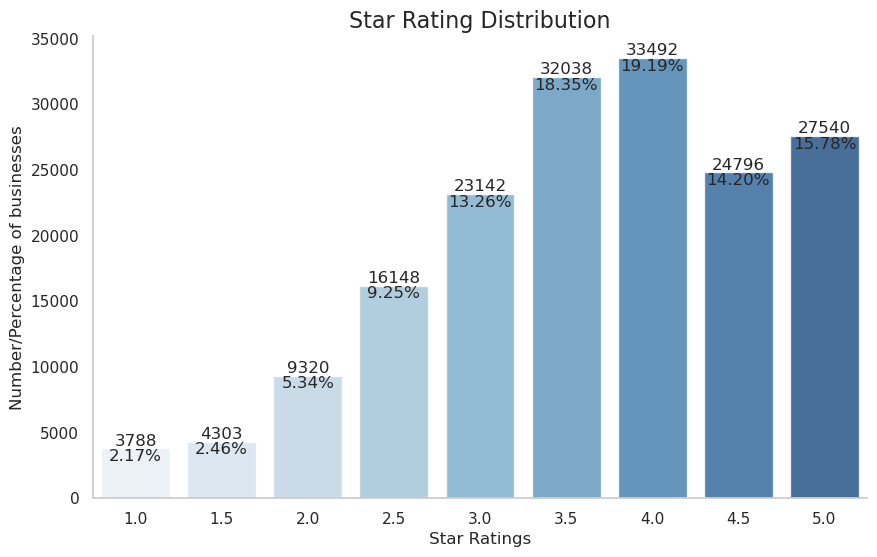

In [34]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
x = base['stars'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
color_palette = sns.color_palette("Blues", len(x))
ax = sns.barplot(x=x.index, y=x.values, alpha=0.8, palette=color_palette)
sns.set_style("whitegrid", {"axes.facecolor": "white"})
ax.yaxis.grid(False)
plt.title("Star Rating Distribution", fontsize=16)
plt.ylabel('Number/Percentage of businesses', fontsize=12)
plt.xlabel('Star Ratings', fontsize=12)
rects = ax.patches
count_labels = x.values
for rect, label in zip(rects, count_labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2,
        height + 5,
        label,
        ha='center',
        va='bottom'
    )    
p = base['stars'].value_counts(normalize=True).sort_index() * 100
rects = ax.patches
percentage_labels = p.values
for rect, label in zip(rects, percentage_labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2,
        height - 15,  
        f'{label:.2f}%',
        ha='center',
        va='top'
    )
sns.despine(top=True)
plt.show()


This histogram provides an overview of the distribution of star ratings across all businesses in the dataset. The x-axis represents the star ratings, and the y-axis represents the number of businesses with each rating. The result shows that the majority of businesses have ratings above 3 stars (around 80%) and centred around 3.5 to 4 stars (37.54%). This graph explains how star ratings are distributed, which can be used as a performance indicator for restaurants. Although it doesn't specifically address the aspect of food delivery and population, it gives a broad overview for my study.

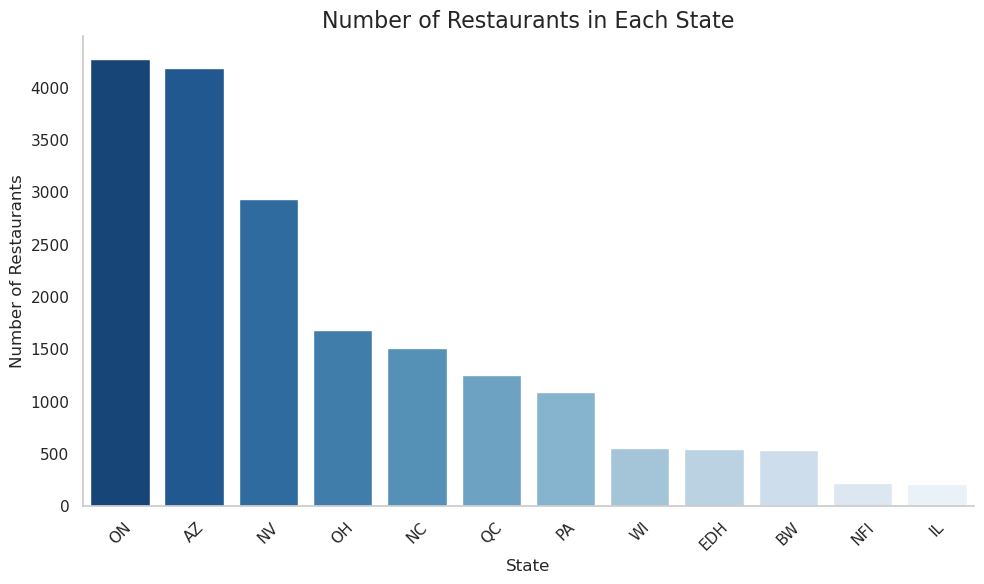

In [35]:
warnings.simplefilter(action='ignore', category=FutureWarning)
colors = sns.color_palette('Blues_r', len(restaurant['state_category'].value_counts()))
plt.figure(figsize=(10, 6))
sns.countplot(data=restaurant, x='state_category', order=restaurant['state_category'].value_counts().index, palette=colors)
plt.title('Number of Restaurants in Each State', fontsize=16)
plt.xlabel('State')
plt.ylabel('Number of Restaurants')
plt.xticks(rotation=45)
sns.despine(top=True)
plt.grid(False)
plt.tight_layout()
plt.show()


This bar plot illustrates the number of restaurants in each state category. Each bar represents a state, and its height indicates the number of restaurants located in that state. This plot helps me identify which states have the highest concentration of restaurants, providing a potential representative state to focus on for further analysis. Since I want to find a representative state of Yelp restaurant in the US. I will choose Arizona (AZ) because it has the second-largest amount of Yelp restaurants in our dataset following the Ontario (ON) from Canada. 

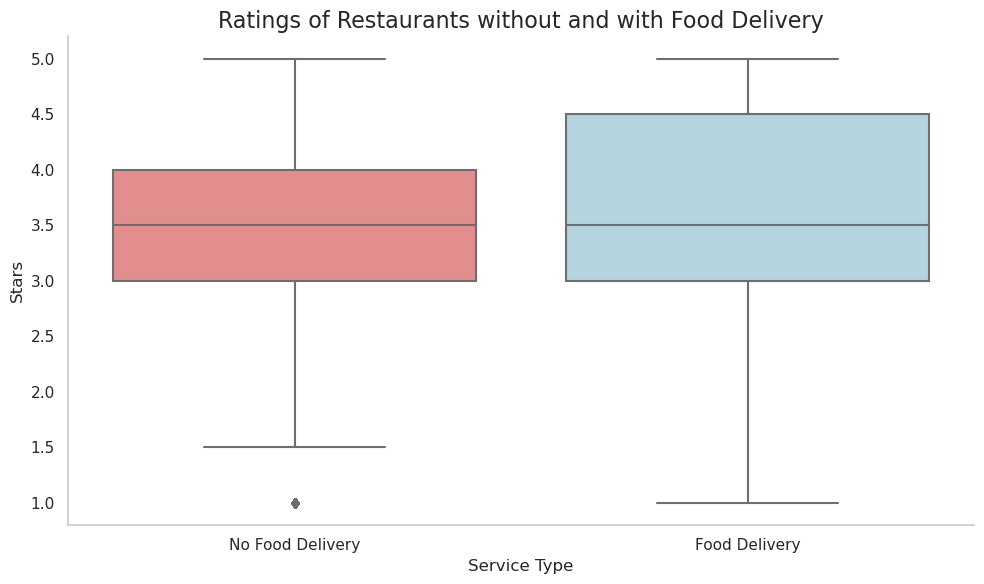

In [36]:
warnings.simplefilter(action='ignore', category=FutureWarning)
# The side-by-side boxplot for the ratings of restaurants that provide food delivery or not
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
colors = {True: 'lightblue', False: 'lightcoral'}
boxplot = sns.boxplot(data=restaurant_delivery, x='has_food_delivery', y='stars', palette=colors)
boxplot.set_xticklabels(['No Food Delivery', 'Food Delivery'])

plt.title('Ratings of Restaurants without and with Food Delivery', fontsize=16)
plt.xlabel('Service Type')
plt.ylabel('Stars')
sns.despine(top=True)
plt.grid(False)
plt.tight_layout() 
plt.show()


This side-by-side boxplot compares the distribution of star ratings for restaurants that provide food delivery (True) and those that do not (False). Each box represents the interquartile range (IQR) of ratings for each group, with the median marked by a horizontal line in between. This plot directly addresses the impact of food delivery services on restaurant ratings, which is a key aspect of my research question. The medians of both groups are the same (3.5 stars), but there are differences in the quartiles. Restaurants with food delivery have a higher upper quartile (75th percentile) compared to those without, suggesting that restaurants with food delivery may have slightly higher ratings on the upper end.

### New merged datasets (For final project)

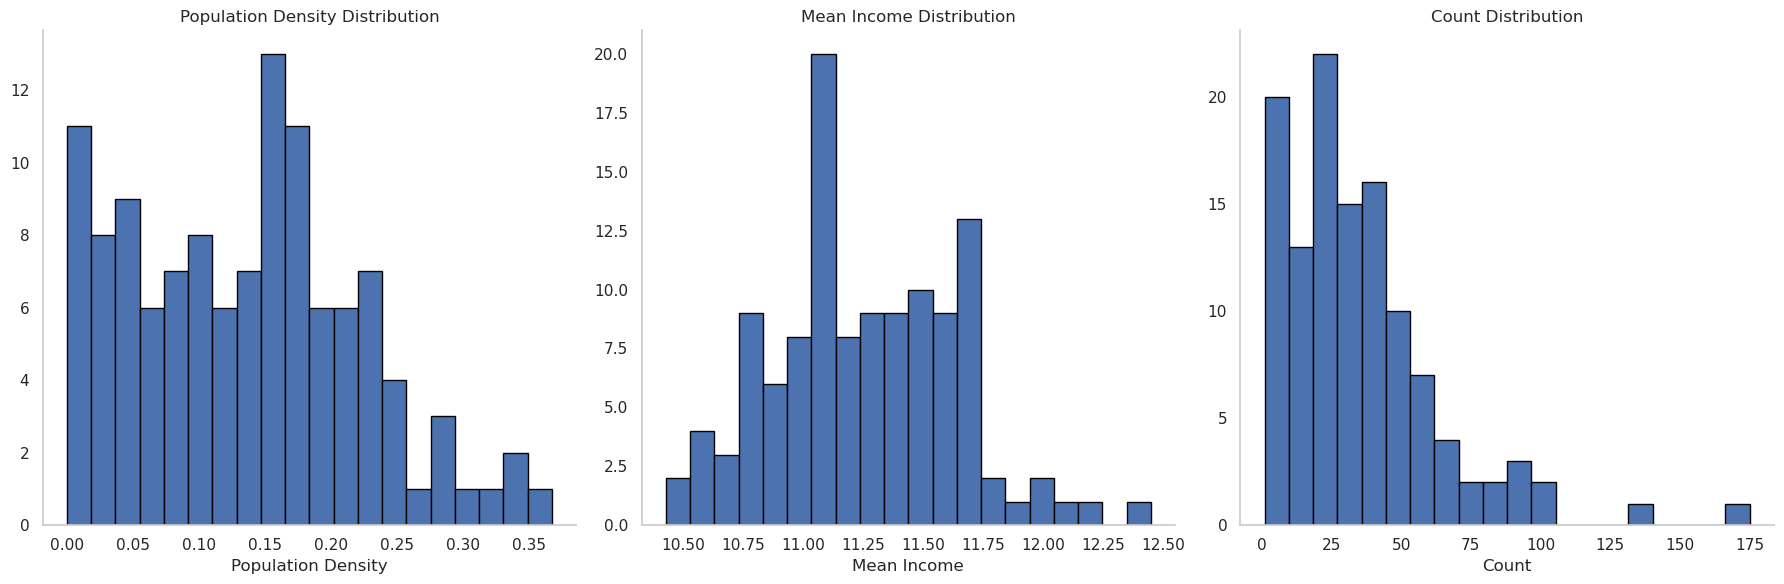

In [37]:
population_density = Final_regression['population_density']
mean_income = Final_regression['Mean_Income']
count = Final_regression['count']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Population Density Histogram
axes[0].hist(population_density, bins=20, edgecolor='black')
axes[0].set_title('Population Density Distribution')
axes[0].set_xlabel('Population Density')
axes[0].set_ylabel('')
axes[0].grid(False)

# Mean Income Histogram
axes[1].hist(mean_income, bins=20, edgecolor='black')
axes[1].set_title('Mean Income Distribution')
axes[1].set_xlabel('Mean Income')
axes[1].set_ylabel('')
axes[1].grid(False)

# Count Histogram
axes[2].hist(count, bins=20, edgecolor='black')
axes[2].set_title('Count Distribution')
axes[2].set_xlabel('Count')
axes[2].set_ylabel('')
axes[2].grid(False)

sns.despine(top=True)
plt.tight_layout()
plt.show()



Now I am demonstrating three important variables that are listed in the summary statistics table, and the visualization would be a better support to learn more about the distribution of these data:

1. **Population Density Distribution:**
   - This histogram shows the distribution of population density across different zip code areas.
   - The x-axis represents population density values, while the y-axis represents the frequency (number of geographic areas) falling within each population density range.


2. **Mean Income Distribution:**
   - This histogram visualizes the distribution of mean income across different zip code areas.
   - The x-axis represents mean income values, and the y-axis represents the frequency of geographic areas in each income range.


3. **Count Distribution:**
   - This histogram illustrates the distribution of Numbers of restaurants across different zip code areas.
   - The x-axis represents the "count" values, and the y-axis represents the frequency of geographic areas with each "count" value.


# Project Two

## The Message

The central focus of this investigation revolves around establishing a potential correlation between the success of restaurants listed on Yelp (as indicated by their star ratings) and the prevalence of food delivery services, particularly in the context of rising population densities.

Drawing inspiration from a study on Chinese urbanization, which mentions that heightened population density leads to intensified competition and consequently, the survival of only the finest dining establishments offering exceptional fare and services. This notion suggests that in areas characterized by the presence of high-quality restaurants, the average star ratings should naturally be elevated. This idea is supported by Matti's (2020) study about Competition and Consumer Reviews in Phoenix that clustering is an explanation for why more nearby competitors are associated with higher ratings. To visually illustrate this concept, I intend to employ scatterplots accompanied by regression lines.

While definitive conclusions remain elusive at this juncture, my visualization aims to take you on an insightful expedition, peeling back layers to reveal potential revelations. It will delve deep into the intricate interplay between population density and mean restaurant ratings, dissected by the availability of food delivery services within the confines of Arizona. The plan is to build a split scatter plot with two panels

The left panel will elucidate the correlation between the average star ratings of restaurants offering food delivery services and the density of the population, depicted through the use of blue markers and regression lines. In contrast, the right panel will mirror the same relationship for restaurants that do not provide delivery services, using red markers and corresponding regression lines. Ultimately, my goal is to offer an intuitive exploration of the potential answers to this important question through graphs.

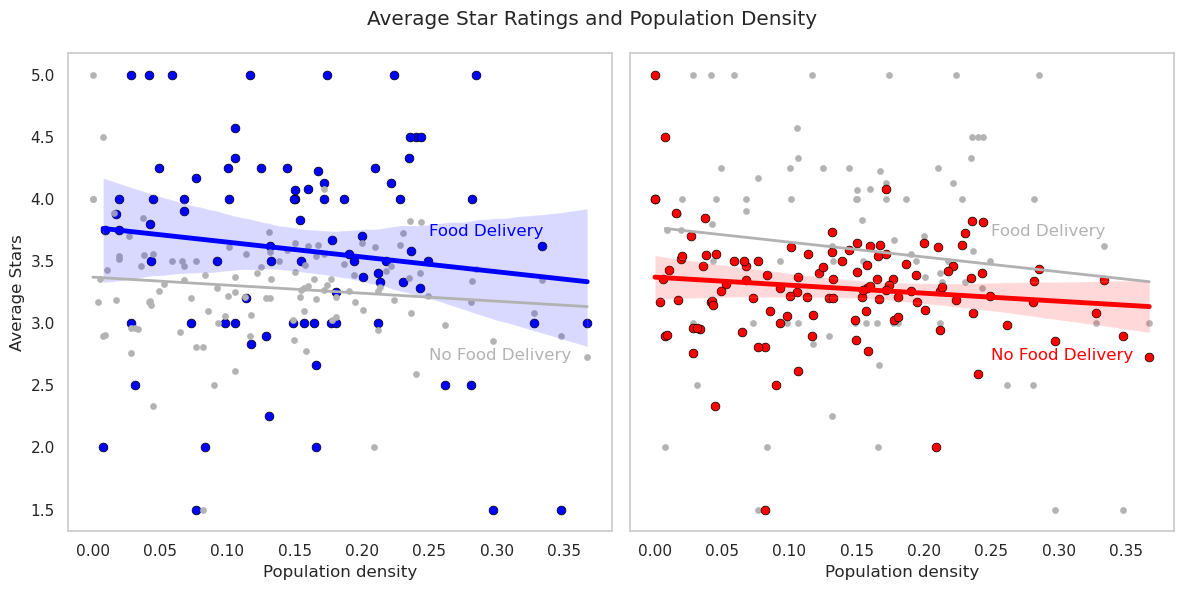

In [38]:
sns.set(style="whitegrid")
# Create the scatter plot
plt.figure(figsize=(12, 6))
plt.suptitle('Average Star Ratings and Population Density')

plt.subplot(1, 2, 1)
sns.scatterplot(x='population_density', y='FD_star', data=zip_states_total, color='blue', marker='o', edgecolor='black', s=40)
sns.scatterplot(x='population_density', y='Non_FD_star', data=zip_states_total, color=(0.7, 0.7, 0.7), marker='o', edgecolor=(0.7, 0.7, 0.7), s=20)
sns.regplot(x='population_density', y='FD_star', data=zip_states_total, color='blue', scatter=False, line_kws={'lw': 3.5})
sns.regplot(x='population_density', y='Non_FD_star', data=zip_states_total, color=(0.7, 0.7, 0.7), scatter=False, ci=None, line_kws={'lw': 2})

plt.grid(False)
plt.xlabel('Population density')
plt.ylabel('Average Stars')
plt.tick_params(axis='x', which='both', bottom=False, top=False)
plt.title('')
plt.text(0.25, 3.7, 'Food Delivery', color='blue')
plt.text(0.25, 2.7, 'No Food Delivery', color=(0.7, 0.7, 0.7))

plt.subplot(1, 2, 2)
sns.scatterplot(x='population_density', y='FD_star', data=zip_states_total, color=(0.7, 0.7, 0.7), marker='o', edgecolor=(0.7, 0.7, 0.7), s=20)
sns.scatterplot(x='population_density', y='Non_FD_star', data=zip_states_total, color='red', marker='o', edgecolor='black' ,s=40)
sns.regplot(x='population_density', y='Non_FD_star', data=zip_states_total, color='red', scatter=False, line_kws={'lw': 3.5})
sns.regplot(x='population_density', y='FD_star', data=zip_states_total, color=(0.7, 0.7, 0.7), scatter=False, ci=None, line_kws={'lw': 2})

plt.grid(False)
plt.xlabel('Population density')
plt.ylabel('')
plt.gca().axes.get_yaxis().set_visible(False)
plt.tick_params(axis='x', bottom=False)
plt.title('')
plt.tight_layout()
plt.text(0.25, 2.7, 'No Food Delivery', color='red')
plt.text(0.25, 3.7, 'Food Delivery', color=(0.7, 0.7, 0.7))

plt.show()

1. **Diverse Rating Trends with Population Density:**
   - One striking observation from the visualization is the decrease in average star ratings as population density rises. This phenomenon is evident for both food delivery and non-food delivery Yelp restaurants in Arizona.
   
2. **Similar Slopes, Contrasting Steadiness:**
   - While the slopes of the regression lines are quite similar for both categories, indicating a shared sensitivity to population density, there are still differences exist in the steadiness of the trends.
   - Restaurants that do not provide food delivery services showcase a flatter regression line, implying that their average ratings respond more consistently to changes in population density.
   - On the other hand, restaurants with food delivery exhibit a steeper regression line, suggesting that the presence of delivery services amplifies the impact of population density on ratings.
   
3. **Potential Delivery Advantage:**
   - A noteworthy insight surfaces in the form of an elevation in average ratings for restaurants that offer food delivery services. This distinction is approximately 0.2 stars in average higher than their non-delivery counterparts.
   
4. **Confidence Intervals and Spread:**
   - The variability in data distribution becomes apparent through the spread of dots in the scatter plots. Restaurants providing delivery services display a wider spread compared to their non-delivery counterparts.
   - Consequently, the wider confidence interval associated with delivery restaurants' regression line implies a greater level of uncertainty in their rating response to population density changes.

In summary, the visualization sheds light on the relationship between population density, average restaurant ratings, and the presence of food delivery services. Notably, as population density increases, average ratings for both restaurant categories tend to decline, underscoring the competitive nature of densely populated areas. However, the introduction of food delivery services introduces nuanced dynamics that warrant more in-depth examination. To draw definitive conclusions, additional research involving regression and machine learning models is imperative. This ongoing work is essential to provide a comprehensive understanding of the factors at play in this complex relationship.

## Maps and Interpretations

During my study focused on Arizona, I conducted an analysis of Yelp restaurants based on their locations within the state. After plotting the restaurants into the state map, I found that the majority of these restaurants were clustered around the Phoenix area. To delve deeper into this trend, I've decided to narrow my investigation by limiting the latitude and longitude ranges. This refined approach will enable me to conduct a focused case study specifically centered on Phoenix. By filtering the data to encompass a precise geographical range, I aim to gain a more comprehensive understanding of the restaurant landscape in this prominent city. This strategic adjustment will not only allow for a more detailed analysis but also provide insights into the unique culinary scene that Phoenix has to offer.

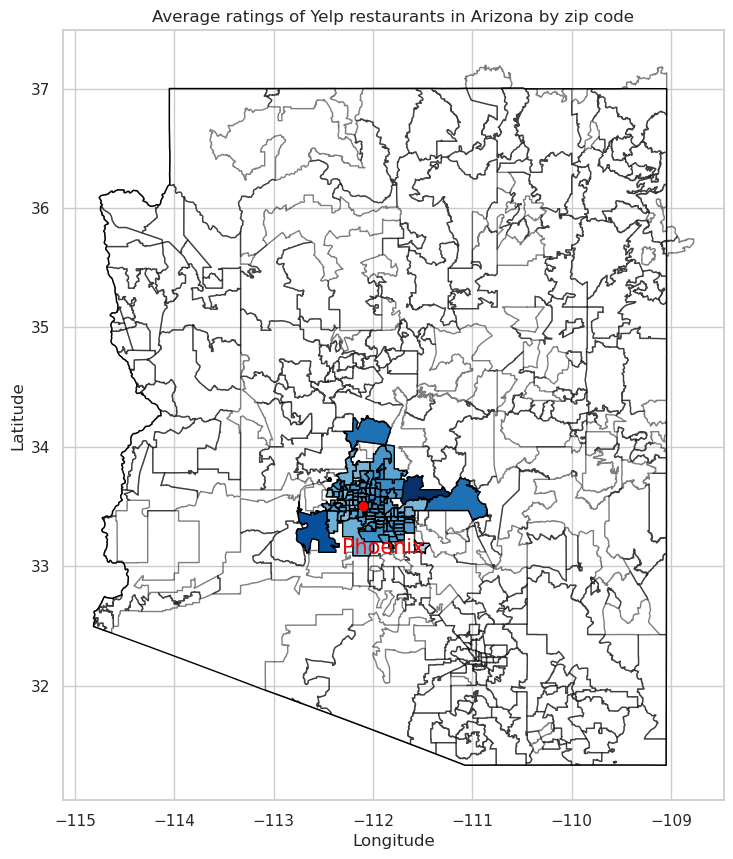

In [39]:
fig, ax = plt.subplots(figsize=(10, 10))
arizona_state_df.plot(ax=ax, edgecolor="black", color="none")
arizona_zip_df.plot(ax=ax, edgecolor="black", color="none", alpha=0.5) 

zip_states_star_avg.plot(
    ax=ax, edgecolor='black', column='stars', legend=False, cmap='Blues',
    vmin=1, vmax=5
)

phoenix_coords = (33.5, -112.1)
# Plot a red point for Phoenix and add label
ax.scatter(phoenix_coords[1], phoenix_coords[0], color='red')
ax.text(phoenix_coords[1] - 0.21, phoenix_coords[0]-0.4, 'Phoenix', fontsize=15, color='red')
plt.title("Average ratings of Yelp restaurants in Arizona by zip code")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

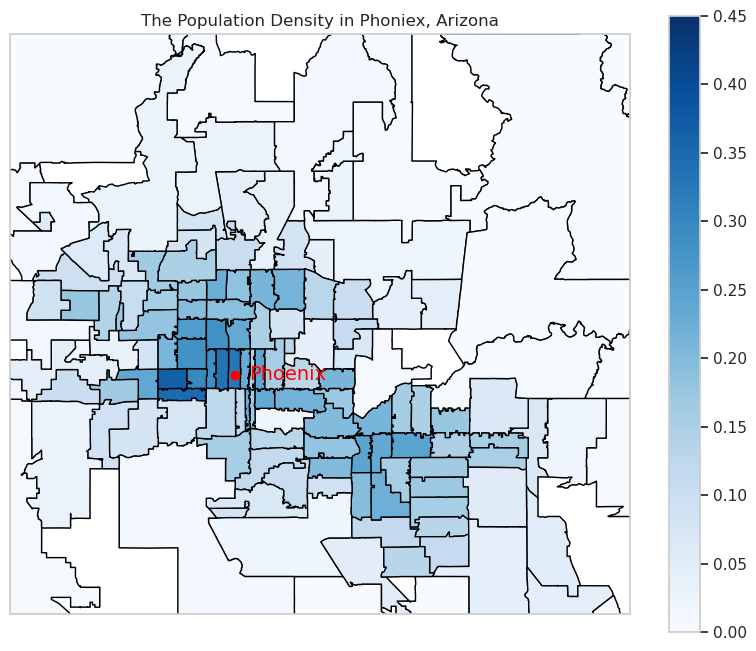

In [40]:
# Population density
fig, ax = plt.subplots(figsize=(10, 8))

arizona_state_df.plot(ax=ax, edgecolor="black", color="none")
arizona_zip_df.plot(ax=ax, edgecolor="black", color="none", alpha=0.5)

zip_states_pop.plot(
    ax=ax, edgecolor='black', column='population_density', legend=True, cmap='Blues',
    vmin=0, vmax=0.45
)

phoenix_coords = (33.5, -112.1)
ax.scatter(phoenix_coords[1], phoenix_coords[0], color='red')
ax.text(phoenix_coords[1] + 0.025, phoenix_coords[0]-0.007, 'Phoenix', fontsize=14, color='red')
ax.set_xlim([-112.5, -111.4]) 
ax.set_ylim([33.15, 34.0])   
plt.title("The Population Density in Phoniex, Arizona")
ax.set_xticks([])
ax.set_yticks([])
plt.xlabel("")
plt.ylabel("")

plt.show()

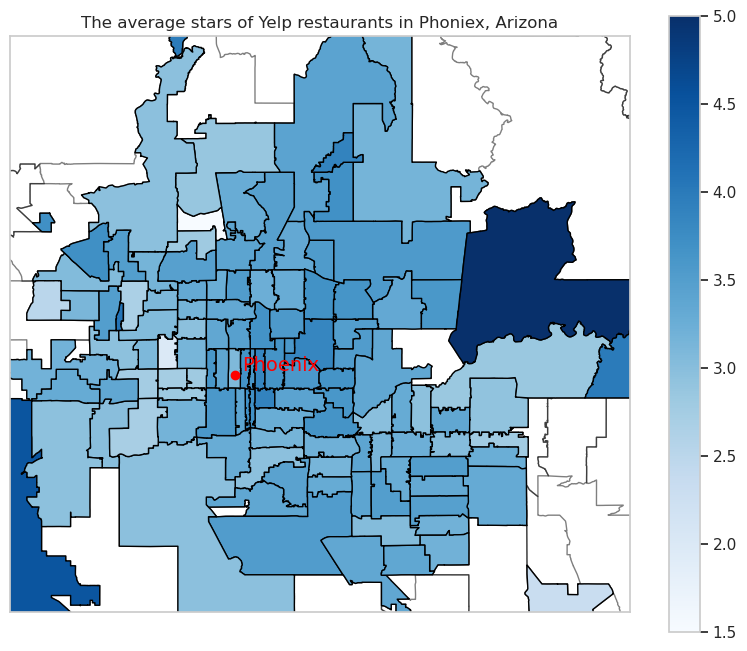

In [41]:
#Average stars
fig, ax = plt.subplots(figsize=(10, 8))
arizona_state_df.plot(ax=ax, edgecolor="black", color="none")
arizona_zip_df.plot(ax=ax, edgecolor="black", color="none", alpha=0.5) 

zip_states_star_avg.plot(
    ax=ax, edgecolor='black', column='stars', legend=True, cmap='Blues',
    vmin=1.5, vmax=5
)

phoenix_coords = (33.5, -112.1)
ax.scatter(phoenix_coords[1], phoenix_coords[0], color='red')
ax.text(phoenix_coords[1] + 0.011, phoenix_coords[0]+0.005, 'Phoenix', fontsize=14, color='red')
ax.set_xlim([-112.5, -111.4])  
ax.set_ylim([33.15, 34.0])   
plt.title("The average stars of Yelp restaurants in Phoniex, Arizona")
ax.set_xticks([])
ax.set_yticks([])
plt.xlabel("")
plt.ylabel("")

plt.show()

**Case Study: Urban Concentration and Restaurant Ratings in Phoenix**

Through the intersection of population density and average Yelp restaurant ratings, a captivating spatial narrative emerges on the maps of Phoenix, Arizona. As we explore this dynamic landscape, several crucial observations come to light:

**1. Population Density and Geographical Patterns:**

   - The map meticulously illustrates the spatial distribution of population density around Phoenix, revealing vibrant clusters of red in areas closer to the west of the city center.
   
   - These high-density zones are intriguingly encircled by expanses marked by cooler blue hues, indicative of lower population density.

**2. Influence on Restaurant Ratings:**

   - Curiously, the areas characterized by higher population density exhibit a distinctive pattern in terms of average Yelp restaurant ratings.
   
   - Within these regions of heightened urban concentration, the ratings transition from neutral white to cooler blue tones, indicating a lower average ratings (lower than 3).
   
   - Conversely, the peripheral areas surrounding the high-density zones are characterized by a dominant presence of warmer red shades, suggesting more favorable restaurant ratings (stars of 3.5 to 4.0).
   
   - This comparison highlights an intriguing dynamic that may be related to customer tastes and dining experiences between urban centres and the areas that surround them.


In summary, the fusion of population density and average Yelp restaurant ratings on the map offers a profound glimpse into the dynamics of urban concentration, dining experiences, and customer choices in Phoenix. This visualization provides a unique lens through which to explore the complex interaction between demographic patterns and restaurant performance, shedding light on the intricate interplay that shapes the city's culinary landscape.


### Mapping of New merged dataset

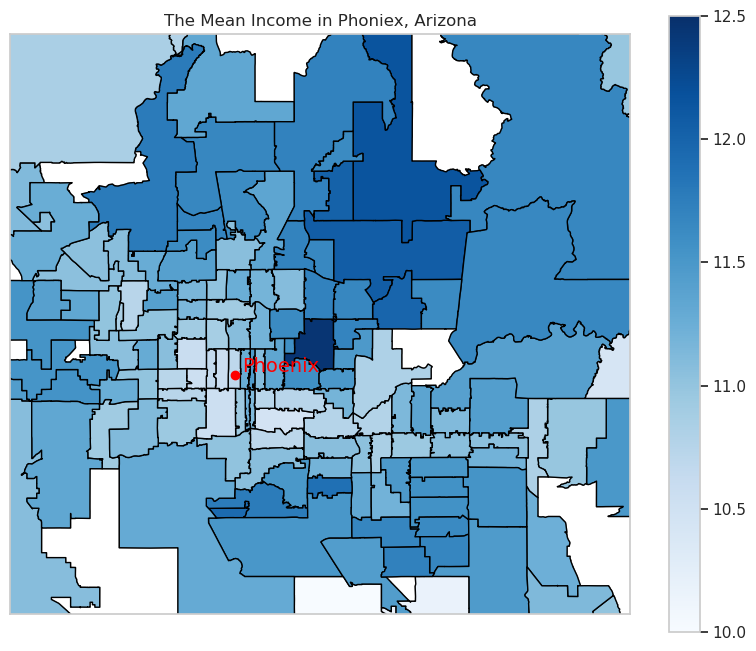

In [42]:
# Mean Income
fig, ax = plt.subplots(figsize=(10, 8))
arizona_state_df.plot(ax=ax, edgecolor="black", color="none")
arizona_zip_df.plot(ax=ax, edgecolor="black", color="none", alpha=0.5) 
zip_states_Income.plot(
    ax=ax, edgecolor='black', column='Mean_Income', legend=True, cmap='Blues',
    vmin=10, vmax=12.5
)

phoenix_coords = (33.5, -112.1)
ax.scatter(phoenix_coords[1], phoenix_coords[0], color='red')
ax.text(phoenix_coords[1] + 0.011, phoenix_coords[0]+0.005, 'Phoenix', fontsize=14, color='red')
ax.set_xlim([-112.5, -111.4])  
ax.set_ylim([33.15, 34.0])   
plt.title("The Mean Income in Phoniex, Arizona")
ax.set_xticks([])
ax.set_yticks([])
plt.xlabel("")
plt.ylabel("")

plt.show()

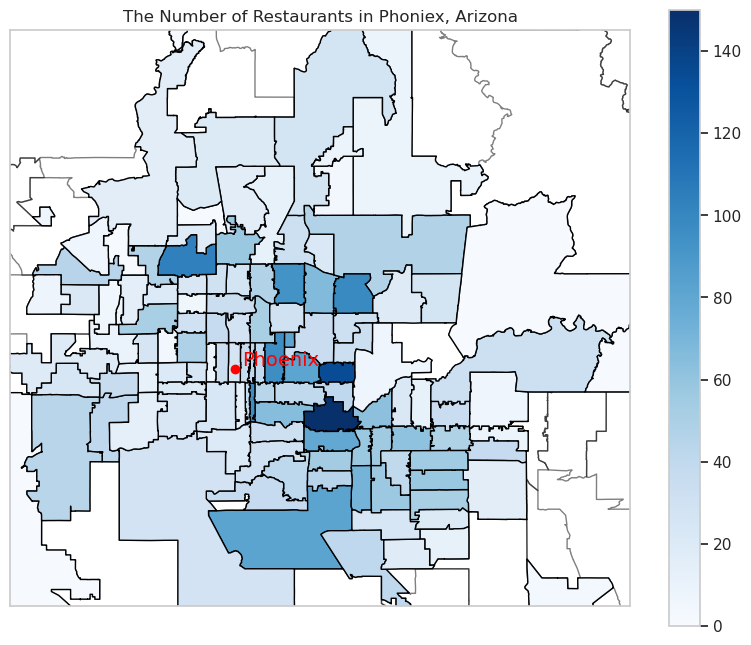

In [43]:
# Count
fig, ax = plt.subplots(figsize=(10, 8))
arizona_state_df.plot(ax=ax, edgecolor="black", color="none")
arizona_zip_df.plot(ax=ax, edgecolor="black", color="none", alpha=0.5) 
zip_states_count.plot(
    ax=ax, edgecolor='black', column='count', legend=True, cmap='Blues',
    vmin=0, vmax=150
)

phoenix_coords = (33.5, -112.1)
ax.scatter(phoenix_coords[1], phoenix_coords[0], color='red')
ax.text(phoenix_coords[1] + 0.011, phoenix_coords[0]+0.005, 'Phoenix', fontsize=14, color='red')
ax.set_xlim([-112.5, -111.4])  
ax.set_ylim([33.15, 34.0])   
plt.title("The Number of Restaurants in Phoniex, Arizona")
ax.set_xticks([])
ax.set_yticks([])
plt.xlabel("")
plt.ylabel("")

plt.show()

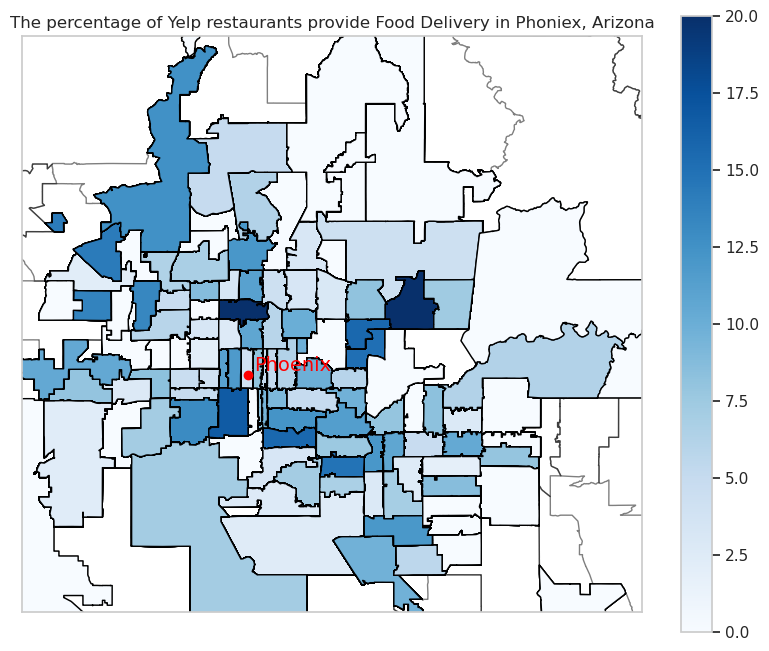

In [44]:
# percentage_delivery
fig, ax = plt.subplots(figsize=(10, 8))
arizona_state_df.plot(ax=ax, edgecolor="black", color="none")
arizona_zip_df.plot(ax=ax, edgecolor="black", color="none", alpha=0.5) 
zip_states_nfd.plot(
    ax=ax, edgecolor='black', column='percentage_delivery', legend=True, cmap='Blues',
    vmin=0, vmax=20
)

phoenix_coords = (33.5, -112.1)
ax.scatter(phoenix_coords[1], phoenix_coords[0], color='red')
ax.text(phoenix_coords[1] + 0.011, phoenix_coords[0]+0.005, 'Phoenix', fontsize=14, color='red')
ax.set_xlim([-112.5, -111.4])  
ax.set_ylim([33.15, 34.0])   
plt.title("The percentage of Yelp restaurants provide Food Delivery in Phoniex, Arizona")
ax.set_xticks([])
ax.set_yticks([])
plt.xlabel("")
plt.ylabel("")

plt.show()

These three supplementary maps offer a deeper comprehension of the analysis by presenting summary statistics and data visualization for three pivotal variables within my study. These variables include the Mean Household Income within each zip code, the count of restaurants per zip code, and the percentage of restaurants that offer food delivery services. These maps are instrumental in enhancing our grasp of how these variables interrelate with the primary factors of population density and Yelp star ratings. By further scrutinizing these relationships, we can enrich our understanding of the research question, facilitating more informed preparation for subsequent regression analyses.


